# plotting

> Functions to plot mutation results

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp plotting

In [ ]:
#| hide
from nbdev.showdoc import *


In [ ]:
#| export
from fastcore.basics import *
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import numpy as np
from Bio import SeqIO
from typing import Union
from dgrec.utils import str_to_mut
import dgrec.utils


In [ ]:
#| hide
from dgrec.example_data import get_example_data_dir

In [ ]:
#| hide
# data_path=get_example_data_dir()

data_path='C:\\Users\\prochett\\Documents\\dgrec\\dgrec-1\\dgrec\\example_data'
os.listdir(data_path)

['example1_ref.fasta',
 'model_mms_2024_02_14.pickle',
 'paired_example1_R1.fastq.gz',
 'paired_example1_R2.fastq.gz',
 'sacB_example.fastq.gz',
 'sacB_genotypes.csv',
 'sacB_ref.fasta',
 '__init__.py',
 '__pycache__']

In [ ]:
# read_ref_file="/sacB_ref.fasta"
# ref=next(SeqIO.parse(os.path.join(data_path,read_ref_file),"fasta"))


read_ref_file="\\sacB_ref.fasta"
ref=next(SeqIO.parse(data_path+read_ref_file,'fasta'))

ref_seq=str(ref.seq)
gen_list=[]
with open(os.path.join(data_path,"sacB_genotypes.csv"),"r") as handle: 
    reader = csv.reader(handle, delimiter='\t')
    for row in reader:
        gen_list.append((row[0],int(row[1])))

In [ ]:
# read_ref_file_paul='/home/prochett/DGRec/dgrec/example_data/sacB_ref.fasta'
# ref_paul=next(SeqIO.parse(os.path.join(data_path,read_ref_file_paul),"fasta"))

# ref_seq=str(ref_paul.seq)
# gen_list=[]
# with open(os.path.join(data_path,"/home/prochett/DGRec/dgrec/example_data/sacB_genotypes.csv"),"r") as handle: 
#     reader = csv.reader(handle, delimiter='\t')
#     for row in reader:
#         gen_list.append((row[0],int(row[1])))

In [ ]:
#| export
def plot_mutations(gen_list: list, #list of genotypes. Each genotype is a tuple: (string representation of the genotype, number of molecules)
                   ref_seq: str, #reference sequence
                   sample_name: str = None,  #sample name
                   plot_range: Union[tuple,list] = None,  #limits the plot to the specified range
                   TR_range: Union[tuple,list] = None, #when specified creates a shaded box highlighting the position of the TR
                   ):
    
    if not plot_range:
        plot_range=[0,len(ref_seq)]

    L=plot_range[1]-plot_range[0]
    ref_seq=ref_seq[plot_range[0]:plot_range[1]]

    symbols=["A","T","G","C","del","ins","N"]
    mut_arrays=dict([(s,np.zeros(L)) for s in symbols])
    for gen, n in gen_list[1:]: #assumes the genotypes with the most molecules is the WT sequence and skips it
        g=gen.split(',')
        for mut in g:
            if mut:
                mut_from=mut[0]
                ix=int(mut[1:-1])
                k=mut[-1]
                if k=="-":
                    k="del"
                elif mut[0]=="-":
                    k="ins"
                mut_arrays[k][ix]+=n  


    for k in mut_arrays:
        mut_arrays[k]=mut_arrays[k][plot_range[0]:plot_range[1]]



    labels=np.array(range(L))

    fig, ax = plt.subplots(1,1,figsize=(20, 5))

    y=sum(mut_arrays.values())
    colors=["orange","red","green","blue","grey","black"]
    for i,s in enumerate(symbols[:-1]):
        sns.barplot(x=labels,y=y,color=colors[i],ax=ax,label=s)
        y-=mut_arrays[s]

    ax.set_xticks(range(len(ref_seq)))
    ax.set_xticklabels(list(ref_seq))
    ax.set_ylabel("number of molecules")
    ax.set_title(sample_name)
    if TR_range:
        ax.axvspan(max(plot_range[0],TR_range[0]),min(TR_range[1],plot_range[1]),alpha=0.1)
    ax.legend()
    #fig.savefig(base_path+"Plots/png/{}-{}_UMI_corrected_genotypes.png".format(sample.Sample_ID,sample.Sample_Name), dpi=300)
    #fig.savefig(base_path+"Plots/eps/{}-{}_UMI_corrected_genotypes.eps".format(sample.Sample_ID,sample.Sample_Name), format='eps')
    #plt.close()
    return ax
    

In [ ]:
#| export
def plot_mutations_percentage(gen_list: list, #list of genotypes. Each genotype is a tuple: (string representation of the genotype, number of molecules)
                   ref_seq: str, #reference sequence
                   sample_name: str = None,  #sample name
                   plot_range: Union[tuple,list] = None,  #limits the plot to the specified range
                   TR_range: Union[tuple,list] = None, #when specified creates a shaded box highlighting the position of the TR
                   rev_comp=False):
    
    if rev_comp==True:
        gen_list=dgrec.utils.reverse_comp_geno_list(gen_list,ref_seq)
        ref_seq=dgrec.utils.reverse_complement(ref_seq)

    if not plot_range:
        plot_range=[0,len(ref_seq)]

    L=plot_range[1]-plot_range[0]
    ref_seq=ref_seq[plot_range[0]:plot_range[1]]

    count_geno=0
    count_muta=0
    for gen, n in gen_list:
        count_geno+=n


    symbols=["A","T","G","C","del","ins","N"]
    mut_arrays=dict([(s,np.zeros(L)) for s in symbols])
    for gen, n in gen_list: #assumes the genotypes with the most molecules is the WT sequence and skips it
        if gen!='':
            g=gen.split(',')
            count_muta+=n
            for mut in g:
                if mut:
                    mut_from=mut[0]
                    ix=int(mut[1:-1])
                    k=mut[-1]
                    if k=="-":
                        k="del"
                    elif mut[0]=="-":
                        k="ins"
                    mut_arrays[k][ix]+=n  


    for k in mut_arrays:
        mut_arrays[k]=100*(mut_arrays[k][plot_range[0]:plot_range[1]])/count_geno



    labels=np.array(range(L))

    fig, ax = plt.subplots(1,1,figsize=(20, 5))

    y=sum(mut_arrays.values())
    colors=["orange","red","green","blue","grey","black"]
    for i,s in enumerate(symbols[:-1]):
        sns.barplot(x=labels,y=y,color=colors[i],ax=ax,label=s)
        y-=mut_arrays[s]

    ax.set_xticks(range(len(ref_seq)))
    ax.set_xticklabels(list(ref_seq))
    ax.set_ylabel("Percentage of mutated bases")
    ax.set_title(sample_name)
    if TR_range:
        ax.axvspan(max(plot_range[0],TR_range[0]),min(TR_range[1],plot_range[1]),alpha=0.1)
    
    textstr = f'Total % of mutagenized molecules = {np.round(100*count_muta/count_geno,2)} %'
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

    ax.legend()
    #fig.savefig(base_path+"Plots/png/{}-{}_UMI_corrected_genotypes.png".format(sample.Sample_ID,sample.Sample_Name), dpi=300)
    #fig.savefig(base_path+"Plots/eps/{}-{}_UMI_corrected_genotypes.eps".format(sample.Sample_ID,sample.Sample_Name), format='eps')
    #plt.close()
    return (ax,np.round(100*count_muta/count_geno,2))

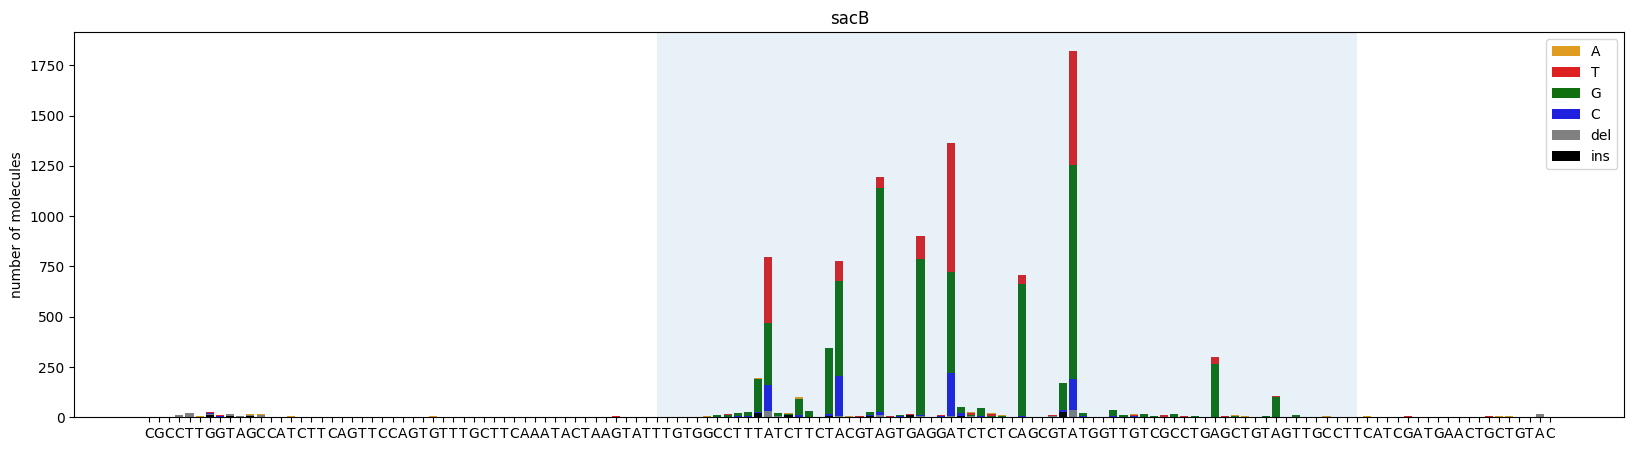

In [ ]:
ax = plot_mutations(gen_list, ref_seq, sample_name="sacB", plot_range=[0,139], TR_range=[50,119])

9.73


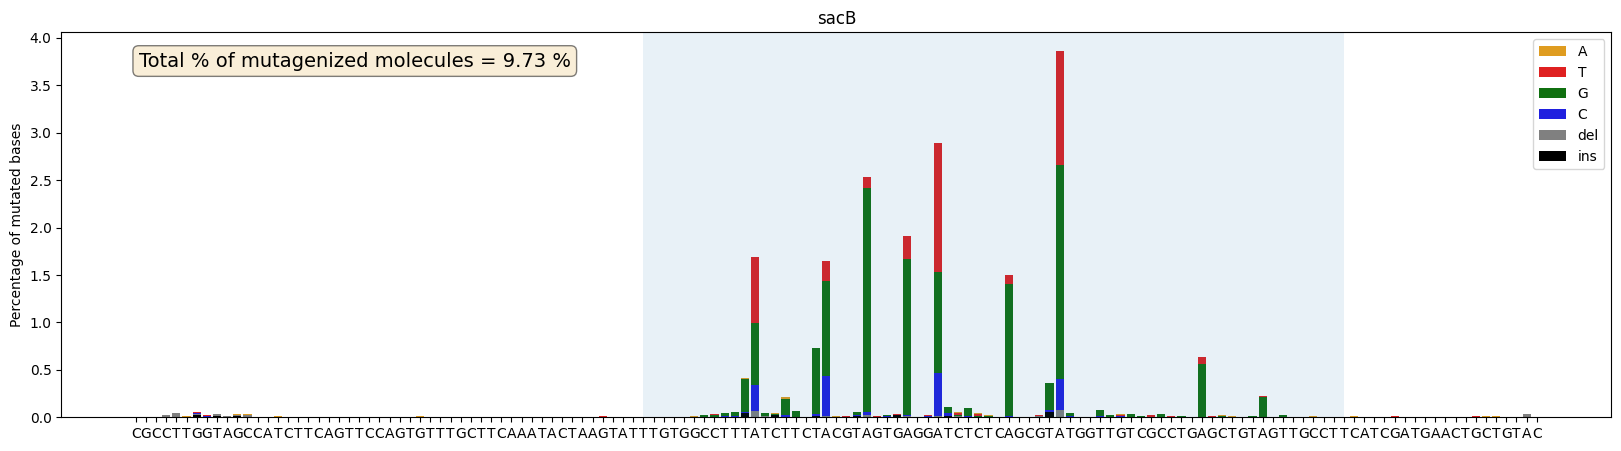

In [ ]:
ax,mut_perc=plot_mutations_percentage(gen_list, ref_seq, sample_name="sacB", plot_range=[0,139], TR_range=[50,119])
plt.show
print(mut_perc)

In [ ]:
ax = plot_mutations_percentage(gen_list, ref_seq, sample_name="sacB", plot_range=[0,139], TR_range=[50,119],rev_comp=True)

AttributeError: module 'dgrec.utils' has no attribute 'reverse_comp_geno_list'

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()